# Core ML: Bayesian NNs via MCMC


## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import time

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Set random seed

np.random.seed(42)

## Prepare noisy XOR dataset

In [3]:
# From https://arxiv.org/pdf/1910.06539.pdf

def simulate_xor(n=np.repeat(100, 4), s=0.25):
	x = np.vstack([
            # points corresponding to (0, 0)
            np.column_stack(
            	[np.random.rand(n[0]) - s, np.random.rand(n[0]) - s]),
            # points corresponding to (0, 1)
            np.column_stack(
            	[np.random.rand(n[1]) - s, np.random.rand(n[1]) + s]),
            # points corresponding to (1, 0)
            np.column_stack(
            	[np.random.rand(n[2]) + s, np.random.rand(n[2]) - s]),
            # points corresponding to (1, 1)
            np.column_stack(
            	[np.random.rand(n[3]) + s, np.random.rand(n[3]) + s])
	])

	y = np.repeat([0, 1, 1, 0], n)

	return x, y


In [4]:
# Define function for simulating noisy XOR points

def simulate_noisy_xor(n, s=0.5):
	
  # x -> n x 2 matrix
  x = np.hstack((
      # x1 -> n x 1 vector
      np.random.rand(n, 1),
      # x2 -> n x 1 vector
      np.random.rand(n, 1)
  ))
  
  temp = np.where(x > s, 1, 0)
  y = np.bitwise_xor(temp[:, 0], temp[:, 1])
  return x, y


In [5]:
# Initialize constants for dataset

num_training_samples = 10000
num_test_samples = 2000

In [6]:
# Create train and test dataset

x_train, y_train = simulate_noisy_xor(num_training_samples)
x_test, y_test = simulate_noisy_xor(num_test_samples)

In [7]:
# Save train dataset to file

train_data_path = Path("data/train")

train_data_path.mkdir(parents=True, exist_ok=True)

np.savetxt(train_data_path.joinpath("x_train.csv"), x_train, delimiter=",", header="x1,x2", comments="")
np.savetxt(train_data_path.joinpath("y_train.csv"), y_train,
           delimiter=",", header="y", comments="")


In [8]:
# Save test dataset to file

test_data_path = Path("data/test")

test_data_path.mkdir(parents=True, exist_ok=True)

np.savetxt(test_data_path.joinpath("x_test.csv"), x_test,
           delimiter=",", header="x1,x2", comments="")
np.savetxt(test_data_path.joinpath("y_test.csv"), y_test,
           delimiter=",", header="y", comments="")


## Plot training and test data

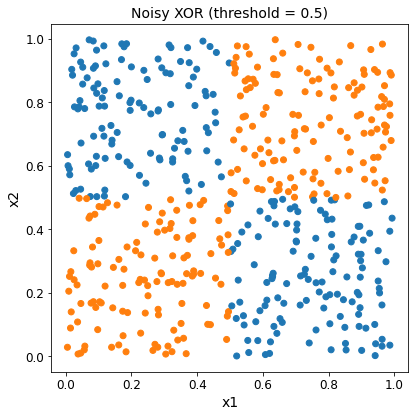

In [9]:
# Setting up plot design

colors = ['#1f77b4', '#ff7f0e']
color_columns = np.where(y_train[:500] == 1, colors[0], colors[1])

labels = ['XOR = 1', 'XOR = 2']
# label_columns = np.where(y_train[:500] == 1, labels[0], labels[1])

plt.figure(figsize=[6.4, 6.4])

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

plt.xlabel("x1")
plt.ylabel("x2")

plt.title("Noisy XOR (threshold = 0.5)")

output_path = Path("data/imgs")
output_path.mkdir(parents=True, exist_ok=True)

# Plot training data

plt.scatter(x_train[:500, 0], x_train[:500, 1], c=color_columns)

# Save plot for reference

plt.savefig(
    output_path.joinpath('noisy_xor_training_set.jpg'),
    pil_kwargs={'quality': 100},
    transparent=True,
    bbox_inches='tight',
    pad_inches=0.1
)


## MLP

Atleast 1 hidden layer required to replicate XOR function, with non-linearity. 

In [10]:
# Helper functions

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def relu(x):
  return x * (x > 0)

def nll_likelihood(y, y_pred):
  return -1.0 * np.sum((y - y_pred) ** 2)

def epoch_time(start, end):
  elapsed_time = end - start
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time  - (elapsed_mins * 60))

  return elapsed_mins, elapsed_secs

In [11]:
# MLP implementation from scratch

class MLP():
  def __init__(self):
    self.weights = np.asarray([
        np.random.randn(2, 3),
        np.random.randn(1, 3)
    ], dtype=object)

    self.bias = np.asarray([
        np.random.randn(3, 1),
        np.random.randn(1, 1)
    ], dtype=object)

  def forward(self, x, weights=None, bias=None):
    if weights is None:
      weights = self.weights

    if bias is None:
      bias = self.bias

    x = sigmoid(x @ weights[0] + bias[0].T)
    out = sigmoid(x @ weights[1].T + bias[1])

    return out


In [12]:
def generate_weights(weights, biases):
  prop_layer_weights = np.asarray([
      np.random.randn(2, 3) + weights[0],
      np.random.randn(1, 3) + weights[1]
  ], dtype=object)

  prop_layer_biases = np.asarray([
      np.random.randn(3, 1) + biases[0],
      np.random.randn(1, 1) + biases[1]
  ], dtype=object)

  # print(prop_layer_weights.shape)
  # print(prop_layer_biases.shape)

  return prop_layer_weights, prop_layer_biases

def accuracy(data, labels, model):
  predictions = []
  for x in data:
    x_new = model.forward(x)
    if x_new > 0.5:
      predictions.append(1)
    else:
      predictions.append(0)
    
    accuracy = (labels == predictions).sum() / labels.shape[0]
  return accuracy

def acceptance(old_ll, new_ll):
  if new_ll > old_ll:
    return True
  else:
    acceptance_diff = np.log(np.random.uniform())
    return (new_ll - old_ll) > acceptance_diff

def prior(weights, biases):
  sum = 0
  for weight in weights:
    sum += -1.0 * np.sum(weight ** 2)

  for bias in biases:
    sum += -1.0 * np.sum(bias ** 2)
  
  return sum

In [13]:
from sklearn.metrics import accuracy_score
def metropolis_hastings(data, labels, epochs, model):
  accepted_proposals = []
  rejected_proposals = []

  accuracy = []

  for epoch in range(epochs):
    start_time = time.time()

    weights = model.weights
    biases = model.bias
    new_weights, new_biases = generate_weights(weights, biases)

    current_prediction = model.forward(data, weights, biases)
    new_prediction = model.forward(data, new_weights, new_biases)

    current_prediction = current_prediction.squeeze()
    new_prediction = new_prediction.squeeze()

    new_likelihood = nll_likelihood(labels, new_prediction) + prior(new_weights, new_biases)
    current_likelihood = nll_likelihood(labels, current_prediction) + prior(weights, biases)

    if acceptance(current_likelihood, new_likelihood):
      final_weight = new_weights
      final_bias = new_biases
      accepted_proposals.append([final_weight, final_bias])
    else:
      final_weight = weights
      final_bias = biases
      rejected_proposals.append([final_weight, final_bias])
    
    model.weights = final_weight
    model.bias = final_bias

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if epoch % 100 == 0:
      current_accuracy = accuracy_score(labels, model.forward(data) > 0.5)
      accuracy.append(current_accuracy)
      print(f"Epoch: {epoch: 02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
      print(f"\tAccuracy Score: {current_accuracy: .3f}")

      
  return accepted_proposals, rejected_proposals, accuracy

In [14]:
# Initialize model
xor_model = MLP()

In [15]:
# Check shape of data before training

x_train.shape, y_train.shape

((10000, 2), (10000,))

In [16]:
# Train model using Bayesian Statistics

accept, reject, train_acc = metropolis_hastings(x_train, y_train, 10000, xor_model)

Epoch:  0 | Epoch Time: 0m 0s
	Accuracy Score:  0.481
Epoch:  100 | Epoch Time: 0m 0s
	Accuracy Score:  0.681
Epoch:  200 | Epoch Time: 0m 0s
	Accuracy Score:  0.739
Epoch:  300 | Epoch Time: 0m 0s
	Accuracy Score:  0.765
Epoch:  400 | Epoch Time: 0m 0s
	Accuracy Score:  0.765
Epoch:  500 | Epoch Time: 0m 0s
	Accuracy Score:  0.765
Epoch:  600 | Epoch Time: 0m 0s
	Accuracy Score:  0.759
Epoch:  700 | Epoch Time: 0m 0s
	Accuracy Score:  0.812
Epoch:  800 | Epoch Time: 0m 0s
	Accuracy Score:  0.825
Epoch:  900 | Epoch Time: 0m 0s
	Accuracy Score:  0.825
Epoch:  1000 | Epoch Time: 0m 0s
	Accuracy Score:  0.825
Epoch:  1100 | Epoch Time: 0m 0s
	Accuracy Score:  0.825
Epoch:  1200 | Epoch Time: 0m 0s
	Accuracy Score:  0.825
Epoch:  1300 | Epoch Time: 0m 0s
	Accuracy Score:  0.825
Epoch:  1400 | Epoch Time: 0m 0s
	Accuracy Score:  0.825
Epoch:  1500 | Epoch Time: 0m 0s
	Accuracy Score:  0.825
Epoch:  1600 | Epoch Time: 0m 0s
	Accuracy Score:  0.821
Epoch:  1700 | Epoch Time: 0m 0s
	Accuracy 

### Analyzing accuracy scores

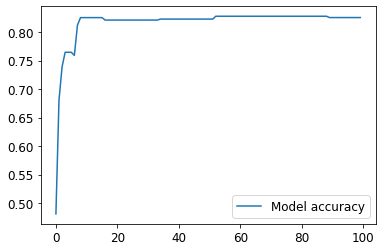

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(train_acc, label = "Model accuracy")
plt.legend()
plt.show()

plt.savefig(
    output_path.joinpath('model_accuracy.jpg'),
    pil_kwargs={'quality': 100},
    transparent=True,
    bbox_inches='tight',
    pad_inches=0.1
)

### Implementing random sampler

In [18]:
def random_acceptor():
  if(np.random.uniform(0,1)>=0.5):
    return True
  else:
    return False

def generate_random_weights(weights, biases):
  prop_layer_weights = np.asarray([
      np.random.randn(2, 3) * abs(np.random.randn() * 0.1) + weights[0],
      np.random.randn(1, 3) * abs(np.random.randn() * 0.1) + weights[1]
  ], dtype=object)

  prop_layer_biases = np.asarray([
      np.random.randn(3, 1) * abs(np.random.randn() * 0.1) + biases[0],
      np.random.randn(1, 1) * abs(np.random.randn() * 0.1) + biases[1]
  ], dtype=object)


  return prop_layer_weights, prop_layer_biases


def random_sampler(data, labels, epochs, model):
  accepted_proposals = []
  rejected_proposals = []

  accuracy = []

  for epoch in range(epochs):
    start_time = time.time()

    weights = model.weights
    biases = model.bias
    new_weights, new_biases = generate_random_weights(weights, biases)

    current_prediction = model.forward(data, weights, biases)
    new_prediction = model.forward(data, new_weights, new_biases)

    current_prediction = current_prediction.squeeze()
    new_prediction = new_prediction.squeeze()

    new_likelihood = nll_likelihood(labels, new_prediction) + prior(new_weights, new_biases)
    current_likelihood = nll_likelihood(labels, current_prediction) + prior(weights, biases)

    if random_acceptor:
      final_weight = new_weights
      final_bias = new_biases
      accepted_proposals.append([final_weight, final_bias])
    else:
      final_weight = weights
      final_bias = biases
      rejected_proposals.append([final_weight, final_bias])
    
    model.weights = final_weight
    model.bias = final_bias

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if epoch % 100 == 0:
      current_accuracy = accuracy_score(labels, model.forward(data) > 0.5)
      accuracy.append(current_accuracy)
      print(f"Epoch: {epoch: 02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
      print(f"\tAccuracy Score: {current_accuracy: .3f}")

      
  return accepted_proposals, rejected_proposals, accuracy

In [19]:
# Initialize model
xor_model = MLP()

# Train model using Random Sampler
accept, reject, train_acc = random_sampler(x_train, y_train, 1000, xor_model)

Epoch:  0 | Epoch Time: 0m 0s
	Accuracy Score:  0.501
Epoch:  100 | Epoch Time: 0m 0s
	Accuracy Score:  0.501
Epoch:  200 | Epoch Time: 0m 0s
	Accuracy Score:  0.501
Epoch:  300 | Epoch Time: 0m 0s
	Accuracy Score:  0.501
Epoch:  400 | Epoch Time: 0m 0s
	Accuracy Score:  0.501
Epoch:  500 | Epoch Time: 0m 0s
	Accuracy Score:  0.367
Epoch:  600 | Epoch Time: 0m 0s
	Accuracy Score:  0.360
Epoch:  700 | Epoch Time: 0m 0s
	Accuracy Score:  0.521
Epoch:  800 | Epoch Time: 0m 0s
	Accuracy Score:  0.499
Epoch:  900 | Epoch Time: 0m 0s
	Accuracy Score:  0.499


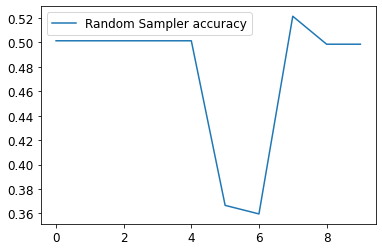

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(train_acc, label = "Random Sampler accuracy")
plt.legend()
plt.show()

plt.savefig(
    output_path.joinpath('random_sampler_accuracy.jpg'),
    pil_kwargs={'quality': 100},
    transparent=True,
    bbox_inches='tight',
    pad_inches=0.1
)